Strong branching works by (for a minimisation problem) calculating the reduction in the dual bound gained by branching on each variable, and then branching on the variable with the largest reduction in the dual bound. This is equivalent to a '1-step lookahead' in the dual bound reduction for each candidate variable.

If we were too lookahead n-steps, as n tends towards the number of steps needed to converge on an optimal solution (where the primal-dual gap is 0), you will converge on the globally optimum solution. However, strong branching is expensive, and even n=1 (1-step lookahead) SB does not scale.

An open question might be; how much better can we be than 1-step strong branching? We can test this by implementing n-step strong branching, and seeing if e.g. n=2 gives better results (in terms of e.g. number of nodes in search tree) than for n=1. If it makes little difference for a given problem, this means that for this particular problem, n=1 strong branching is close to the optimal branching policy. In this case, we wouldn't expect our agent to even beat SB, only tend towards imitating it. If n!=1 does result in improvement, we would expect our RL agent to be able to work out how to beat strong branching, or at least find actions which are different to SB.

In this notebook, we will implement n-step strong branching and apply it to small 100x100 set cover instances to try to answer the question; how much scope is there to improve beyond 1-step strong branching for these instance sizes?

To implement n-step strong branching, at each step in the episode, we will:

1. Save the dual bound value at the current step
2. For i in range(n): do strong branching at each step. 
3. After the n-th step, calculate the dual bound reduction from branching at each variable relative to the initial dual bound saved at step 1. The variable which resulted in the largest dual bound decrease 



In [1]:
import retro_branching
from retro_branching.environments import EcoleBranching

import ecole

from collections import defaultdict
import copy
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
class StrongBranchingAgent:
    def __init__(self, name='sb'):
        self.name = name
        self.strong_branching_function = ecole.observation.StrongBranchingScores()

    def before_reset(self, model):
        """
        This function will be called at initialization of the environment (before dynamics are reset).
        """
        self.strong_branching_function.before_reset(model)
    
    def extract(self, model, done, **kwargs):
        return self.strong_branching_function.extract(model, done)

    def action_select(self, action_set, model, done):
        scores = self.extract(model, done)[action_set]
        action = scores.argmax()
        
        # DEBUG
        print('sb action set: {}'.format(action_set))
        print('sb scores: {}'.format({action: score for action, score in zip(action_set, scores)}))
        print('sb action: idx={} (action={})'.format(action, action_set[action]))
        
        return action
    
class CustomStrongBranchingAgent:
    def __init__(self, name='sb'):
        self.name = name

    def before_reset(self, model):
        """
        This function will be called at initialization of the environment (before dynamics are reset).
        """
        pass
    
    def extract(self, model, done, action_set, action_history, instance_before_reset):
        action_to_score = {var: 0 for var in range(model.as_pyscipopt().getNVars())}
        for action in action_set:
            env = EcoleBranching(observation_function='default',
                                  information_function='default',
                                  reward_function='default',
                                  scip_params='default')
            env.seed(0)
            _ = env.reset(instance_before_reset.copy_orig())
            
            # rollout to current state
            for a in action_history:
                _ = env.step(a)
            
            m = env.model.as_pyscipopt()
            init_dual_bound = m.getDualbound()
            env.step(action)
            m = env.model.as_pyscipopt()
            final_dual_bound = m.getDualbound()
            action_to_score[action] = abs(init_dual_bound-final_dual_bound)
        return list(action_to_score.values())

    def action_select(self, action_set, model, done):
        scores = self.extract(model, done, action_set)[action_set]
        action = scores.argmax()
        return action
    
class TwoStepStrongBranchingAgent:
    def __init__(self, name='2_step_sb'):
        '''Have not yet implemented N>2 since have many trajectories to track. For now use N=2.'''
        self.N = 2
        self.name = name
    
    def before_reset(self, model):
        # initialises and resets sb functions when self.extract() called so no need to do anything here
        pass
        
    def extract(self, instance_before_reset, env, _action_history, action_set, done):
        action_history = copy.deepcopy(_action_history)
            
        # init tracking of step -> action -> scores trajectories
        step_scores = {step: defaultdict(lambda: 0) for step in range(1, self.N+1)}
            
        # init env for each candidate branching variable
        obs_func, info_func, reward_func, scip_params = env.str_observation_function, env.str_information_function, env.str_reward_function, env.str_scip_params
        envs = {action: EcoleBranching(observation_function=obs_func,
                                        information_function=info_func,
                                        reward_function=reward_func,
                                        scip_params=scip_params)
               for action in action_set}
        
        # init env to <step_return_params> maps
        env_to_action_set = {e: None for e in envs.keys()}
        env_to_done = {e: None for e in envs.keys()}
        env_to_action_history = {e: copy.deepcopy(action_history) for e in envs.keys()}

        # init corresponding sb agents to use for each env
        sb_agents = {e: CustomStrongBranchingAgent() # CustomStrongBranchingAgent() StrongBranchingAgent()
               for e in envs.keys()}

        # reset envs and sb agents and rollout to current state
        for key in envs.keys():
            envs[key].seed(0)
            sb_agents[key].before_reset(instance_before_reset.copy_orig())
            _, env_to_action_set[key], _, env_to_done[key], _ = envs[key].reset(instance_before_reset.copy_orig())
            for a in action_history:
                _, env_to_action_set[key], _, env_to_done[key], _ = envs[key].step(a)

        # get 1-step sb scores for each action, and branch on this action
        scores = sb_agents[key].extract(model=envs[key].model, done=done, action_set=env_to_action_set[key], action_history=env_to_action_history[key], instance_before_reset=instance_before_reset.copy_orig())
        scores = np.nan_to_num(scores)[env_to_action_set[key]]
        keep_running = True
        for idx, action in enumerate(env_to_action_set[key]):
            step_scores[1][action] += scores[idx]
            _, env_to_action_set[action], _, env_to_done[action], _ = envs[action].step(action)
            env_to_action_history[action].append(action)
            if env_to_done[action]:
                # this was first agent to solve problem, no need to do 2-step lookahead after
                keep_running = False
        
        # get range(2, N+1)-step scores for each action
        for n in range(2, self.N+1):
            if keep_running:
                for key in envs.keys():

                    if not env_to_done[key]:
                        # get sb scores
                        s = sb_agents[key].extract(model=envs[key].model, done=env_to_done[key], action_set=env_to_action_set[key], action_history=env_to_action_history[key], instance_before_reset=instance_before_reset.copy_orig())
                        # set nans to 0
                        s = np.nan_to_num(s)
                        # filter out invalid actions from scores
                        s = s[env_to_action_set[key]]
                        # get sb action index
                        a_idx = np.argmax(s)
                        env_to_action_history[key].append(env_to_action_set[key][a_idx])
                        # store action score
                        step_scores[n][key] += s[a_idx]
                        # step env with SB score
                        _, env_to_action_set[key], _, env_to_done[key], _ = envs[key].step(env_to_action_set[key][a_idx])
                        if env_to_done[key]:
                            # this was first agent to solve problem, no need to keep running other agents
                            keep_running = False
                            break
        
        # calc total dual bound reduction for each action's trajectory
        action_to_score = {action: 0 for action in action_set}
        for action in action_set:
            for n in step_scores.keys():
                if action in step_scores[n]:
                    action_to_score[action] += step_scores[n][action]

        return action_to_score, step_scores
        
    def action_select(self, instance_before_reset, env, action_history, action_set, done):
        scores, step_scores = self.extract(instance_before_reset=instance_before_reset, env=env, _action_history=action_history, action_set=action_set, done=done)
        action = np.where(max(scores, key=scores.get)==action_set)
        
        # DEBUG
        print('2-step sb action set: {}'.format(action_set))
        print('2-step sb step -> action -> scores: {}'.format(step_scores))
        print('2-step sb action: idx={} (action={})'.format(action, max(scores, key=scores.get)))
        
        return action
            
        
        
    

In [3]:
# agents
one_agent = StrongBranchingAgent()
two_agent = TwoStepStrongBranchingAgent()

# envs
one_env = EcoleBranching(observation_function='default',
                          information_function='default',
                          reward_function='default',
                          scip_params='default')
one_env.seed(0)
two_env = EcoleBranching(observation_function='default',
                          information_function='default',
                          reward_function='default',
                          scip_params='default')
two_env.seed(0)

# instances
instances = ecole.instance.SetCoverGenerator(n_rows=100, n_cols=100, density=0.05)

In [4]:
num_episodes = 100
metrics = ['num_nodes', 'solving_time', 'lp_iterations']

plot_dict = {'1_step_sb': {metric: [] for metric in metrics},
             '2_step_sb': {metric: [] for metric in metrics}}
for ep in range(num_episodes):
    print('\n\n>>> Episode {} <<<'.format(ep))
    
    # find an instance not pre-solved by environment
    one_obs = None
    while one_obs is None:
        one_env.seed(0)
        instance = next(instances)
        instance_before_reset = instance.copy_orig()
        one_agent.before_reset(instance_before_reset.copy_orig())
        one_obs, one_action_set, one_reward, one_done, one_info = one_env.reset(instance)
    two_env.seed(0)
    two_obs, two_action_set, two_reward, two_done, two_info = two_env.reset(instance_before_reset.copy_orig())
    
    # 1-step SB agent
    # DEBUG
    m = one_env.model.as_pyscipopt()
    print('\ninit 1-step sb dual/primal/gap: {}/{}/{}'.format(m.getDualbound(), m.getPrimalbound(), m.getGap()))
    t = 1
    while not one_done:
        print(f'> t={t}')
        prev_dual = m.getDualbound()
        one_action = one_agent.action_select(one_action_set, one_env.model, one_done)
        one_action = one_action_set[one_action]
        one_obs, one_action_set, one_reward, one_done, one_info = one_env.step(one_action)
        # DEBUG
        m = one_env.model.as_pyscipopt()
        curr_dual = m.getDualbound()
        print('1-step sb dual/primal/gap: {}/{}/{} (dual change = {})'.format(m.getDualbound(), m.getPrimalbound(), m.getGap(), curr_dual-prev_dual))
        t += 1
    for metric in metrics:
        plot_dict['1_step_sb'][metric].append(one_info[metric])
    print('>> 1-step SB num nodes: {}'.format(one_info['num_nodes']))
        
    # 2-step SB agent
    # DEBUG
    m = two_env.model.as_pyscipopt()
    print('\ninit 2-step sb dual/primal/gap: {}/{}/{}'.format(m.getDualbound(), m.getPrimalbound(), m.getGap()))
    action_history = [] # store history of 2-step sb actions taken so can rollout envs to current state
    t = 1
    while not two_done:
        print(f'> t={t}')
        prev_dual = m.getDualbound()
        two_action = two_agent.action_select(instance_before_reset=instance_before_reset.copy_orig(), env=two_env, action_history=action_history, action_set=two_action_set, done=two_done)
        two_action = two_action_set[two_action]
        action_history.append(two_action)
        two_obs, two_action_set, two_reward, two_done, two_info = two_env.step(two_action)
        # DEBUG
        m = two_env.model.as_pyscipopt()
        curr_dual = m.getDualbound()
        print('2-step sb dual/primal/gap: {}/{}/{} (dual change = {})'.format(m.getDualbound(), m.getPrimalbound(), m.getGap(), curr_dual-prev_dual))
        t += 1
    for metric in metrics:
        plot_dict['2_step_sb'][metric].append(two_info[metric])
    print('>> 2-step SB num nodes: {}'.format(two_info['num_nodes']))



>>> Episode 0 <<<

init 1-step sb dual/primal/gap: 589.75/603.0/0.022467147096227214
> t=1
sb action set: [ 4 13 14 15 22 26 27 29 45 47 53 60 62 63 70 88 93 96]
sb scores: {4: 101.0633249999998, 13: 101.0625, 14: 33.0, 15: 67.37554999999986, 22: 61.250499999999874, 26: 150.0649500099994, 27: 54.0, 29: 10.0, 45: 38.75, 47: 73.50059999999985, 53: 61.250499999999874, 60: 101.0625, 62: 76.56312499999984, 63: 150.0649500099994, 70: 150.0649500099994, 88: 47.5, 93: 76.56312499999984, 96: 76.56312499999984}
sb action: idx=5 (action=26)
1-step sb dual/primal/gap: 603.0/603.0/0.0 (dual change = 13.25)
>> 1-step SB num nodes: 3.0

init 2-step sb dual/primal/gap: 589.75/603.0/0.022467147096227214
> t=1
2-step sb action set: [ 4 13 14 15 22 26 27 29 45 47 53 60 62 63 70 88 93 96]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {4: 8.25, 13: 0.0, 14: 0.0, 15: 0.0, 22: 5.0, 26: 13.25, 27: 0.0, 29: 0

2-step sb action set: [ 5 20 22 29 30 32 36 41 42 50 52 53 54 55 57 63 71 73 75 77 81 83 84 86]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {5: 0.0, 20: 1.25, 22: 0.0, 29: 0.0, 30: 1.5833333333333712, 32: 0.0, 36: 0.0, 41: 3.25, 42: 3.25, 50: 3.25, 52: 2.0, 53: 3.25, 54: 3.25, 55: 3.25, 57: 1.0, 63: 3.25, 71: 3.25, 73: 0.0, 75: 3.25, 77: 2.25, 81: 3.25, 83: 2.25, 84: 0.0, 86: 3.25}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {})}
2-step sb action: idx=(array([7]),) (action=41)
2-step sb dual/primal/gap: 819.0/819.0/0.0 (dual change = 3.25)
>> 2-step SB num nodes: 3.0


>>> Episode 6 <<<

init 1-step sb dual/primal/gap: 897.8/900.0/0.002450434395188289
> t=1
sb action set: [ 1 17 20 21 27 28 36 41 44 49 51 54 57 60 66 74 75 76 78 79 82 85 87 88
 90 98 99]
sb scores: {1: 1.4401200000000791, 17: 1.440240010000049, 20: 1.

2-step sb action set: [ 0  6  7 21 29 41 53 59 60 65 73 82 83 84 85 86 87 96 98 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {0: 5.0, 6: 0.0, 7: 0.0, 21: 0.0, 29: 0.0, 41: 0.0, 53: 2.0, 59: 0.0, 60: 7.2000000000000455, 65: 0.0, 73: 2.0, 82: 0.0, 83: 0.0, 84: 0.0, 85: 7.2000000000000455, 86: 12.600000000000023, 87: 0.0, 96: 0.0, 98: 5.0, 99: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {0: 9.71428571428578, 6: 9.0, 7: 18.0})}
2-step sb action: idx=(array([2]),) (action=7)
2-step sb dual/primal/gap: 866.0/886.0/0.023094688221709007 (dual change = 0.0)
> t=2
2-step sb action set: [ 1  6 21 22 25 29 38 47 48 53 56 59 65 73 74 81 82 83 84 86 96 98 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {1: 7.20000000000004

2-step sb action set: [ 2 15 17 20 23 27 28 29 30 37 38 39 51 59 60 61 64 76 82 91 93]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {2: 1.6000000000000227, 15: 1.6000000000000227, 17: 0.6000000000000227, 20: 0.6000000000000227, 23: 1.6000000000000227, 27: 0.2666666666666515, 28: 0.0, 29: 0.6000000000000227, 30: 1.6000000000000227, 37: 1.6000000000000227, 38: 1.6000000000000227, 39: 1.6000000000000227, 51: 1.6000000000000227, 59: 1.6000000000000227, 60: 0.6000000000000227, 61: 0.6000000000000227, 64: 1.6000000000000227, 76: 1.6000000000000227, 82: 1.6000000000000227, 91: 0.6000000000000227, 93: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {})}
2-step sb action: idx=(array([0]),) (action=2)
2-step sb dual/primal/gap: 779.0/779.0/0.0 (dual change = 1.6000000000000227)
>> 2-step SB num nodes: 3.0


>>> Episode 14 <<<



2-step sb action set: [ 2  4 21 30 37 42 47 49 58 62 64 66 67 70 75 82 84 87 95 96]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {2: 0.0, 4: 0.0, 21: 4.666666666666629, 30: 4.666666666666629, 37: 4.666666666666629, 42: 0.0, 47: 2.6666666666666288, 49: 4.666666666666629, 58: 4.666666666666629, 62: 0.0, 64: 0.0, 66: 2.3333333333332575, 67: 3.4166666666666288, 70: 2.3333333333332575, 75: 0.0, 82: 4.666666666666629, 84: 4.666666666666629, 87: 2.1666666666666288, 95: 0.0, 96: 4.666666666666629}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {})}
2-step sb action: idx=(array([2]),) (action=21)
2-step sb dual/primal/gap: 747.0/747.0/0.0 (dual change = 4.666666666666629)
>> 2-step SB num nodes: 3.0


>>> Episode 19 <<<

init 1-step sb dual/primal/gap: 664.7142857142857/667.0/0.0034386417365141505
> t=1
sb action set: [ 0  6  7  9

2-step sb action set: [ 0  2  5  6  7  8 11 13 16 26 28 30 34 36 37 41 47 48 56 58 59 60 67 68
 79 83 85 86 92 97 98 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {0: 10.375, 2: 0.0, 5: 0.375, 6: 1.375, 7: 0.5178571428571104, 8: 4.75, 11: 1.7083333333333712, 13: 0.0, 16: 0.0, 26: 0.0, 28: 0.0, 30: 0.0, 34: 0.0, 36: 0.375, 37: 4.75, 41: 9.375, 47: 0.0, 48: 0.375, 56: 0.375, 58: 0.375, 59: 0.0, 60: 0.0, 67: 3.625, 68: 0.0, 79: 0.0, 83: 0.20833333333337123, 85: 1.7083333333333712, 86: 0.0, 92: 0.375, 97: 0.0, 98: 0.0, 99: 0.375}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {})}
2-step sb action: idx=(array([0]),) (action=0)
2-step sb dual/primal/gap: 823.0/823.0/0.0 (dual change = 10.375)
>> 2-step SB num nodes: 3.0


>>> Episode 25 <<<

init 1-step sb dual/primal/gap: 822.0/836.0/0.0170316301703163
> t=1
sb action set:

2-step sb action set: [ 2  7  9 10 12 16 18 19 22 24 25 26 27 32 33 34 44 47 52 55 57 61 63 66
 68 69 70 73 74 75 76 78 82 83 87 90 91 94 95 96 98 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {2: 0.0, 7: 0.0, 9: 1.4941176470588289, 10: 0.0, 12: 0.0, 16: 0.0, 18: 0.0, 19: 0.0, 22: 0.0, 24: 0.0, 25: 0.0, 26: 0.0, 27: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 44: 0.0, 47: 0.0, 52: 0.0, 55: 0.0, 57: 0.0, 61: 0.0, 63: 0.0, 66: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 73: 0.0, 74: 0.0, 75: 0.0, 76: 4.524886877827953, 78: 0.0, 82: 0.0, 83: 2.5441176470587834, 87: 1.0989956958392213, 90: 3.6018099547510474, 91: 0.0, 94: 0.0, 95: 0.0, 96: 0.0, 98: 0.0, 99: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {2: 5.460784313725412, 7: 3.6018099547510474, 9: 5.228571428571399, 10: 5.460784313725412, 12: 2.5441176470587834, 16: 1.2032085561496615, 1

2-step sb action set: [ 0  1  2 11 12 15 16 17 20 21 25 26 31 32 34 36 37 38 43 44 49 56 58 60
 62 67 68 71 76 78 84 92 95 97 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {0: 0.0, 1: 0.0, 2: 0.0, 11: 0.0, 12: 0.0, 15: 0.0, 16: 0.0, 17: 0.0, 20: 0.0, 21: 0.0, 25: 0.0, 26: 0.0, 31: 0.0, 32: 0.0, 34: 0.0, 36: 0.0, 37: 0.0, 38: 0.0, 43: 0.0, 44: 0.0, 49: 0.0, 56: 0.0, 58: 0.0, 60: 0.0, 62: 3.6666666666666288, 67: 0.0, 68: 0.0, 71: 0.0, 76: 0.0, 78: 0.0, 84: 0.0, 92: 0.0, 95: 0.0, 97: 0.0, 99: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a6221440>, {0: 1.6666666666666288, 1: 2.055555555555543, 2: 8.24561403508767, 11: 6.814814814814781, 12: 11.25757575757575, 15: 4.0, 16: 0.29166666666662877, 17: 0.5238095238095184, 20: 4.0, 21: 3.309523809523739, 25: 11.393939393939377, 26: 7.166666666666629, 31: 1.5, 32: 1.6666666666666288, 

2-step sb action set: [ 5  9 13 16 17 18 21 24 30 35 40 41 52 63 64 66 67 71 75 90 93 97]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {5: 0.0, 9: 3.625, 13: 0.0, 16: 2.125, 17: 0.0, 18: 0.0, 21: 0.0, 24: 0.0, 30: 0.0, 35: 0.875, 40: 0.0, 41: 2.125, 52: 0.0, 63: 0.0, 64: 0.0, 66: 0.0, 67: 0.0, 71: 0.875, 75: 2.125, 90: 1.625, 93: 0.0, 97: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a6221050>, {5: 6.625, 9: 4.5, 13: 9.125})}
2-step sb action: idx=(array([2]),) (action=13)
2-step sb dual/primal/gap: 701.875/711.0/0.013000890471950133 (dual change = 0.0)
> t=2
2-step sb action set: [ 5  9 16 17 18 21 24 30 35 40 41 52 57 63 64 66 67 71 75 89 93 97]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {5: 6.625, 9: 4.3250000000000455, 1

2-step sb action set: [ 1  4  6  7  9 10 14 17 21 23 26 30 33 34 36 41 47 54 55 60 62 64 65 69
 73 77 78 85 86 91 94]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {1: 0.0, 4: 3.25, 6: 0.0, 7: 0.5833333333333712, 9: 3.75, 10: 0.75, 14: 0.5833333333333712, 17: 1.25, 21: 0.0, 23: 1.25, 26: 3.25, 30: 0.0, 33: 0.5833333333333712, 34: 0.0, 36: 0.0, 41: 1.25, 47: 0.5499999999999545, 54: 0.0, 55: 0.0, 60: 0.6785714285714448, 62: 0.5833333333333712, 64: 0.0, 65: 0.0, 69: 0.0, 73: 0.0, 77: 0.0, 78: 0.0, 85: 2.75, 86: 3.25, 91: 0.0, 94: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {1: 5.25})}
2-step sb action: idx=(array([0]),) (action=1)
2-step sb dual/primal/gap: 947.75/953.0/0.0055394355051437616 (dual change = 0.0)
> t=2
2-step sb action set: [ 4  6  9 10 17 23 26 30 34 36 40 41 47 54 55 60 64 65 73 77 78 85 86 91]
2-step

2-step sb action set: [ 4  6  7  8 13 15 17 19 22 30 41 44 51 53 54 57 58 61 62 70 71 72 77 79
 85 86 92]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {4: 0.0, 6: 0.0, 7: 0.0, 8: 0.0, 13: 0.0, 15: 0.0, 17: 0.0, 19: 0.0, 22: 0.0, 30: 0.0, 41: 0.0, 44: 0.0, 51: 0.0, 53: 0.0, 54: 0.0, 57: 0.0, 58: 0.0, 61: 0.0, 62: 0.0, 70: 0.0, 71: 0.0, 72: 0.0, 77: 0.0, 79: 0.0, 85: 0.0, 86: 0.0, 92: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {4: 6.1875, 6: 2.0, 7: 0.5555555555555429, 8: 9.666666666666629, 13: 4.5, 15: 8.699999999999932, 17: 2.0, 19: 4.25, 22: 2.0, 30: 8.699999999999932, 41: 3.75, 44: 1.1000000000000227, 51: 4.5, 53: 14.0, 54: 0.5555555555555429, 57: 13.06666666666672, 58: 3.6666666666666288, 61: 3.75, 62: 1.2000000000000455, 70: 3.6666666666666288, 71: 4.583333333333371, 72: 2.5, 77: 6.277777777777828, 79: 4.9166

2-step sb action set: [ 0  2  5  7 13 16 25 29 30 32 35 37 38 41 51 55 59 60 64 68 72 77 79 82
 84 88 94]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {0: 4.366666666666674, 2: 0.0, 5: 0.0, 7: 0.0, 13: 5.7000000000000455, 16: 0.0, 25: 0.033333333333416704, 29: 0.033333333333416704, 30: 0.0, 32: 5.7000000000000455, 35: 1.7000000000000455, 37: 3.6090909090909236, 38: 4.366666666666674, 41: 5.7000000000000455, 51: 0.0, 55: 0.033333333333416704, 59: 0.0, 60: 0.0, 64: 0.0, 68: 0.0, 72: 5.7000000000000455, 77: 3.8333333333333712, 79: 0.0, 82: 0.0, 84: 0.0, 88: 0.0, 94: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {})}
2-step sb action: idx=(array([4]),) (action=13)
2-step sb dual/primal/gap: 746.0/746.0/0.0 (dual change = 5.7000000000000455)
>> 2-step SB num nodes: 3.0


>>> Episode 44 <<<

init 1-step sb dual/primal/gap

2-step sb action set: [ 0  2  5 12 15 17 21 24 26 27 32 38 42 43 44 45 48 49 50 51 55 56 60 62
 68 71 72 76 78 80 81 84 85 86 88 90 91 94 95 96 97 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {0: 0.0, 2: 0.0, 5: 0.0, 12: 0.0, 15: 0.0, 17: 0.0, 21: 0.0, 24: 0.5238095238095184, 26: 0.0, 27: 0.0, 32: 0.0, 38: 0.0, 42: 0.0, 43: 0.0, 44: 7.523809523809518, 45: 0.0, 48: 0.0, 49: 5.35714285714289, 50: 0.0, 51: 0.0, 55: 0.0, 56: 0.0, 60: 0.0, 62: 0.5238095238095184, 68: 0.0, 71: 0.0, 72: 7.523809523809518, 76: 0.0, 78: 1.5238095238095184, 80: 0.0, 81: 0.0, 84: 0.0, 85: 0.0, 86: 0.0, 88: 0.0, 90: 0.0, 91: 0.0, 94: 7.523809523809518, 95: 7.523809523809518, 96: 0.0, 97: 0.0, 99: 6.85714285714289}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {})}
2-step sb action: idx=(array([14]),) (action=44)
2-step sb dual/primal/gap: 863.0/

2-step sb action set: [13 25 26 31 43 75 81]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {13: 2.0, 25: 0.0, 26: 0.0, 31: 2.0, 43: 2.0, 75: 2.0, 81: 2.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {})}
2-step sb action: idx=(array([0]),) (action=13)
2-step sb dual/primal/gap: 762.0/762.0/0.0 (dual change = 2.0)
>> 2-step SB num nodes: 3.0


>>> Episode 52 <<<

init 1-step sb dual/primal/gap: 669.5454545454545/674.0/0.00665308893414806
> t=1
sb action set: [ 1  6 10 19 28 37 39 42 48 52 55 57 60 70 75 77 86 87 90 91]
sb scores: {1: 1.8161157024796022, 6: 0.7066320247935346, 10: 3.297616115702638, 19: 1.8161157024796022, 28: 3.297616115702638, 37: 3.297616115702638, 39: 2.8265280991737454, 42: 3.297616115702638, 48: 11.934229752066315, 52: 8.479584297520844, 55: 1.8843520661159612, 57: 5.88860020661174, 60: 1.8161157024

2-step sb action set: [ 5  6 10 11 12 14 17 19 20 21 22 35 36 37 38 42 44 47 49 54 56 58 63 64
 66 68 69 70 73 75 78 79 80 81 84 86 92 94 97 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {5: 3.071428571428555, 6: 0.0, 10: 0.0, 11: 0.0, 12: 3.071428571428555, 14: 0.0, 17: 0.0, 19: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 35: 0.07142857142855519, 36: 0.0, 37: 0.0, 38: 0.0, 42: 0.0, 44: 0.0, 47: 0.0, 49: 0.0, 54: 0.0, 56: 13.404761904761926, 58: 5.071428571428555, 63: 0.0, 64: 0.0, 66: 0.0, 68: 0.0, 69: 0.0, 70: 0.0, 73: 0.0, 75: 0.0, 78: 0.07142857142855519, 79: 0.0, 80: 0.0, 81: 0.0, 84: 0.0, 86: 0.0, 92: 3.071428571428555, 94: 0.0, 97: 0.0, 99: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {5: 12.5, 6: 15.571428571428555, 10: 19.071428571428555})}
2-step sb action: idx=(array([2]),) (action=10)
2-step sb dual/primal/gap: 

2-step sb action set: [ 0  3  4  5  7 13 14 22 23 26 28 29 30 31 32 33 34 37 38 43 44 47 48 49
 52 53 56 57 58 65 66 69 71 76 78 79 81 83 85 87 89 90 91 92 95 97 98]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {0: 0.6417405318291003, 3: 1.7188854489163532, 4: 0.0, 5: 0.0, 7: 0.0, 13: 0.0, 14: 0.0, 22: 0.0, 23: 0.0, 26: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 0.0, 34: 0.0, 37: 0.0, 38: 0.0, 43: 3.1436974789914984, 44: 0.0, 47: 0.0, 48: 0.0, 49: 0.0, 52: 0.0, 53: 0.0, 56: 0.0, 57: 0.0, 58: 0.0, 65: 0.0, 66: 0.0, 69: 0.0, 71: 0.0, 76: 0.0, 78: 0.0, 79: 1.6685421994884564, 81: 0.9294117647058329, 83: 0.0, 85: 0.0, 87: 0.0, 89: 1.6436974789914984, 90: 0.0, 91: 0.0, 92: 0.0, 95: 3.3884281581484856, 97: 0.0, 98: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {0: 7.143341335969467, 3: 7.110526315789457, 4: 0.1

2-step sb action set: [ 0  2  6 12 14 22 23 27 29 37 47 48 51 53 59 60 68 69 72 73 74 76 84 89
 90 92 93 95 98 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {0: 3.9166666666666288, 2: 3.9166666666666288, 6: 3.9166666666666288, 12: 8.166666666666629, 14: 3.9166666666666288, 22: 8.166666666666629, 23: 3.9166666666666288, 27: 3.9166666666666288, 29: 3.9166666666666288, 37: 3.9166666666666288, 47: 3.9166666666666288, 48: 3.9166666666666288, 51: 3.9166666666666288, 53: 3.9166666666666288, 59: 3.9166666666666288, 60: 8.166666666666629, 68: 3.9166666666666288, 69: 8.166666666666629, 72: 8.166666666666629, 73: 3.9166666666666288, 74: 3.9166666666666288, 76: 3.9166666666666288, 84: 8.166666666666629, 89: 3.9166666666666288, 90: 6.166666666666629, 92: 3.9166666666666288, 93: 3.9166666666666288, 95: 6.166666666666629, 98: 3.9166666666666288, 99: 3.9166666666666288}), 2: defaultdict(<function T

2-step sb action set: [ 2  3  5  7 22 32 40 44 51 60 63 70 82 90 92 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {2: 0.0, 3: 0.0, 5: 0.0, 7: 0.0, 22: 0.0, 32: 0.0, 40: 0.0, 44: 0.0, 51: 0.0, 60: 0.0, 63: 0.0, 70: 0.5, 82: 0.0, 90: 0.0, 92: 0.0, 99: 0.5}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {2: 1.75, 3: 2.6666666666666288, 5: 1.1666666666666288, 7: 2.6666666666666288, 22: 1.9032258064515872, 32: 0.5, 40: 1.1666666666666288, 44: 1.1666666666666288, 51: 3.5, 60: 2.6666666666666288, 63: 3.5, 70: 3.1666666666666288, 82: 3.5, 90: 0.0, 92: 1.1666666666666288, 99: 3.1666666666666288})}
2-step sb action: idx=(array([11]),) (action=70)
2-step sb dual/primal/gap: 751.5/762.0/0.013972055888223553 (dual change = 0.5)
> t=2
2-step sb action set: [ 2  3  5  7 22 40 44 51 60 63 68 78 82 92]
2-step sb step -> action -> score

2-step sb action set: [ 6  7 10 13 16 18 21 32 40 45 48 60 67 72 73 83 84 86 97]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {6: 0.0, 7: 0.0, 10: 0.0, 13: 0.5, 16: 0.0, 18: 0.0, 21: 0.0, 32: 0.0, 40: 5.25, 45: 0.5, 48: 0.0, 60: 9.5, 67: 0.5, 72: 0.0, 73: 1.5, 83: 0.0, 84: 0.0, 86: 0.0, 97: 4.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {})}
2-step sb action: idx=(array([11]),) (action=60)
2-step sb dual/primal/gap: 721.0/721.0/0.0 (dual change = 9.5)
>> 2-step SB num nodes: 3.0


>>> Episode 70 <<<

init 1-step sb dual/primal/gap: 881.1/889.0/0.008966065145840401
> t=1
sb action set: [ 2  5  9 10 16 17 24 25 26 29 30 32 33 36 39 40 41 51 52 53 54 57 69 80
 81 82 83 84 85 88 93 94 95 99]
sb scores: {2: 6.2100899999998, 5: 39.56057333333317, 9: 40.71058999999956, 10: 8.280119999999473, 16: 6.2100899999998, 17: 3.45004

2-step sb action set: [ 1  2 14 19 20 22 26 30 39 52 54 56 62 63 66 68 71 81 85 93 97]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {1: 0.5, 2: 0.5, 14: 3.5, 19: 0.0, 20: 0.0, 22: 0.5, 26: 0.5, 30: 1.5, 39: 2.5, 52: 0.0, 54: 0.0, 56: 0.5, 62: 0.0, 63: 0.0, 66: 0.0, 68: 0.0, 71: 0.0, 81: 0.0, 85: 0.5, 93: 0.0, 97: 0.5}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {})}
2-step sb action: idx=(array([2]),) (action=14)
2-step sb dual/primal/gap: 905.0/905.0/0.0 (dual change = 3.5)
>> 2-step SB num nodes: 3.0


>>> Episode 75 <<<

init 1-step sb dual/primal/gap: 807.5/841.0/0.04148606811145511
> t=1
sb action set: [ 0  2 36 51 60 70 71 83 91]
sb scores: {0: 387.50000000000057, 2: 111.83333333333292, 36: 168.0, 51: 54.77777777777839, 60: 487.5014999999996, 70: 383.0000000000009, 71: 29.25, 83: 29.40000000000009, 91: 118.125}
s

2-step sb action set: [ 6  7 11 12 19 22 26 34 35 38 41 49 56 60 63 65 66 67 72 80 81 87 93 94]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {6: 0.0, 7: 0.0, 11: 1.0, 12: 0.0, 19: 0.0, 22: 0.0, 26: 0.0, 34: 0.1999999999999318, 35: 0.0, 38: 1.5, 41: 1.0, 49: 0.1999999999999318, 56: 0.0, 60: 0.0, 63: 0.1999999999999318, 65: 0.0, 66: 0.0, 67: 0.0, 72: 1.5, 80: 0.0, 81: 0.0, 87: 0.0, 93: 1.0, 94: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {6: 0.5, 7: 2.5})}
2-step sb action: idx=(array([1]),) (action=7)
2-step sb dual/primal/gap: 743.5/746.0/0.0033624747814391394 (dual change = 0.0)
> t=4
2-step sb action set: [ 6 19 38 65 72 80 87]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {6: 0.0, 19: 2.5, 38: 2.5, 65: 0.0, 72: 

2-step sb action set: [40 47 54 57 60 65 83]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {40: 3.0, 47: 3.0, 54: 3.0, 57: 3.0, 60: 3.0, 65: 3.0, 83: 3.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {})}
2-step sb action: idx=(array([0]),) (action=40)
2-step sb dual/primal/gap: 740.0/740.0/0.0 (dual change = 3.0)
>> 2-step SB num nodes: 3.0


>>> Episode 83 <<<

init 1-step sb dual/primal/gap: 649.0/652.0/0.004622496147919877
> t=1
sb action set: [16 22 32 37 55 77 88]
sb scores: {16: 4.0004000099998995, 22: 4.0004000099998995, 32: 4.0004000099998995, 37: 4.0004000099998995, 55: 4.0004000099998995, 77: 4.0004000099998995, 88: 4.0004000099998995}
sb action: idx=0 (action=16)
1-step sb dual/primal/gap: 652.0/652.0/0.0 (dual change = 3.0)
>> 1-step SB num nodes: 3.0

init 2-step sb dual/primal/gap: 649.0/652.0/0.0046224961

2-step sb action set: [ 5  6 10 12 14 17 18 24 26 29 43 47 52 55 59 61 65 68 71 77 79 80 81 83
 90 91 92 95 96 98]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a628cdd0>, {5: 0.0, 6: 0.0, 10: 0.0, 12: 0.0, 14: 11.0, 17: 0.0, 18: 0.0, 24: 0.0, 26: 0.0, 29: 0.0, 43: 0.0, 47: 0.125, 52: 11.0, 55: 0.0, 59: 11.0, 61: 0.0, 65: 0.0, 68: 0.0, 71: 0.0, 77: 0.0, 79: 0.0, 80: 0.0, 81: 11.0, 83: 0.0, 90: 0.0, 91: 0.0, 92: 0.0, 95: 0.0, 96: 0.0, 98: 2.5}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {})}
2-step sb action: idx=(array([4]),) (action=14)
2-step sb dual/primal/gap: 889.0/889.0/0.0 (dual change = 11.0)
>> 2-step SB num nodes: 5.0


>>> Episode 88 <<<

init 1-step sb dual/primal/gap: 742.5/747.0/0.006060606060606061
> t=1
sb action set: [ 1  9 26 28 29 43 46 53 54 55 68 76 77 80 86 89 94]
sb scores: {1: 10.500299999999925, 9: 8.75024

2-step sb action set: [ 1  7  9 11 15 19 22 24 25 27 28 36 55 63 64 67 69 79 81 83 84 85 88 89
 91 95]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {1: 0.0, 7: 0.0, 9: 0.0, 11: 0.0, 15: 0.0, 19: 0.0, 22: 0.0, 24: 0.0, 25: 0.0, 27: 0.0, 28: 0.0, 36: 0.0, 55: 0.0, 63: 0.0, 64: 0.0, 67: 0.0, 69: 0.0, 79: 0.0, 81: 0.0, 83: 0.0, 84: 0.0, 85: 0.0, 88: 0.0, 89: 0.0, 91: 0.0, 95: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {1: 4.25, 7: 7.428571428571445, 9: 10.25, 11: 2.5, 15: 4.25, 19: 12.5, 22: 0.5, 24: 12.25, 25: 0.5, 27: 3.75, 28: 10.25, 36: 4.25, 55: 4.25, 63: 2.4166666666666288, 64: 9.0, 67: 6.0, 69: 10.25, 79: 10.25, 81: 9.125, 83: 12.75, 84: 1.0, 85: 6.5, 88: 9.0, 89: 4.25, 91: 1.0, 95: 10.583333333333371})}
2-step sb action: idx=(array([19]),) (action=83)
2-step sb dual/primal/gap: 891.75/918.0/0.0294365012615643

2-step sb action set: [ 0  2  3  8 11 16 17 18 20 21 22 23 30 34 43 44 46 49 52 53 54 57 63 76
 77 78 80 82 83 85 86 94 95 96]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {0: 0.0, 2: 1.2708333333333712, 3: 0.0, 8: 0.0, 11: 0.0, 16: 3.3333333333333712, 17: 0.0, 18: 0.0, 20: 0.0, 21: 0.0, 22: 0.0, 23: 0.0, 30: 0.0, 34: 9.0, 43: 0.0, 44: 0.0, 46: 0.0, 49: 0.0, 52: 0.0, 53: 0.0, 54: 0.0, 57: 0.0, 63: 0.0, 76: 0.0, 77: 0.0, 78: 0.0, 80: 0.0, 82: 0.0, 83: 0.0, 85: 0.0, 86: 0.0, 94: 0.0, 95: 0.0, 96: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {0: 5.904761904761926, 2: 7.729166666666629, 3: 3.5641025641026545, 8: 9.0, 11: 4.144144144144207, 16: 10.0})}
2-step sb action: idx=(array([5]),) (action=16)
2-step sb dual/primal/gap: 686.0/703.0/0.02478134110787172 (dual change = 3.3333333333333712)
> t=2
2-step sb action set: 

2-step sb action set: [ 0  1 13 30 41 43 55 60 73 83 84 88 95]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9f80>, {0: 0.0, 1: 5.0, 13: 0.0, 30: 5.0, 41: 0.0, 43: 0.0, 55: 2.5, 60: 2.5, 73: 0.0, 83: 5.0, 84: 0.0, 88: 5.0, 95: 5.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {})}
2-step sb action: idx=(array([1]),) (action=1)
2-step sb dual/primal/gap: 859.0/859.0/0.0 (dual change = 5.0)
>> 2-step SB num nodes: 9.0


>>> Episode 96 <<<

init 1-step sb dual/primal/gap: 782.1666666666666/827.0/0.05731941189004906
> t=1
sb action set: [ 4  8 10 11 12 13 14 15 17 20 21 25 30 33 36 44 47 53 60 61 66 67 68 72
 75 76 77 78 81 83 88 90 91 92 93 94 95]
sb scores: {4: 70.7611111111121, 8: 120.48611111111221, 10: 50.22727272727275, 11: 130.42534722222356, 12: 58.44457777777946, 13: 24.277777777778162, 14: 31.073232323232514, 15: 71.60416

2-step sb action set: [ 4 10 11 12 13 14 15 17 20 25 29 30 33 35 36 42 44 47 53 59 60 65 66 67
 68 69 77 79 81 83 88 90 92 94 95 97 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a62a47a0>, {4: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 17: 0.0, 20: 0.0, 25: 0.0, 29: 0.0, 30: 0.0, 33: 0.0, 35: 0.0, 36: 0.0, 42: 0.0, 44: 0.0, 47: 0.0, 53: 0.0, 59: 0.0, 60: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 77: 0.0, 79: 0.0, 81: 0.0, 83: 0.0, 88: 0.0, 90: 0.0, 92: 0.0, 94: 0.0, 95: 0.0, 97: 0.0, 99: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {4: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 17: 0.0, 20: 0.0, 25: 0.0, 29: 0.0, 30: 0.0, 33: 0.0, 35: 0.0, 36: 0.0, 42: 0.0, 44: 0.0, 47: 0.0, 53: 0.0, 59: 0.0, 60: 0.0, 65: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 77: 0.0, 79: 0.0, 81: 0.0, 83: 0.0, 88

2-step sb action set: [ 6 10 11 12 13 14 15 17 20 21 25 29 30 33 35 36 44 53 59 60 66 67 68 69
 77 81 83 88 90 92 94 95 97 99]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624b290>, {6: 0.0, 10: 0.0, 11: 0.0, 12: 0.0, 13: 0.0, 14: 0.0, 15: 0.0, 17: 0.0, 20: 0.0, 21: 0.0, 25: 0.0, 29: 0.0, 30: 0.0, 33: 0.0, 35: 0.0, 36: 0.0, 44: 3.452702702702709, 53: 3.452702702702709, 59: 0.0, 60: 0.0, 66: 0.0, 67: 0.0, 68: 0.0, 69: 0.0, 77: 0.0, 81: 0.0, 83: 3.452702702702709, 88: 0.0, 90: 0.0, 92: 0.0, 94: 0.0, 95: 0.0, 97: 0.0, 99: 0.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a624bcb0>, {6: 0.0, 10: 3.147147147147166, 11: 3.3027027027027316, 12: 3.452702702702709, 13: 3.452702702702709, 14: 3.452702702702709, 15: 0.0, 17: 3.202702702702709, 20: 3.452702702702709, 21: 0.0, 25: 3.452702702702709, 29: 0.0, 30: 0.0, 33: 3.452702702702709, 35: 3.1471471

2-step sb action set: [ 0  8 43 61 84 95 98]
2-step sb step -> action -> scores: {1: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a61f9ef0>, {0: 3.0, 8: 0.0, 43: 5.0, 61: 5.0, 84: 5.0, 95: 5.0, 98: 5.0}), 2: defaultdict(<function TwoStepStrongBranchingAgent.extract.<locals>.<dictcomp>.<lambda> at 0x7f29a628cdd0>, {})}
2-step sb action: idx=(array([2]),) (action=43)
2-step sb dual/primal/gap: 685.0/685.0/0.0 (dual change = 5.0)
>> 2-step SB num nodes: 3.0


>>> Episode 98 <<<

init 1-step sb dual/primal/gap: 741.5/755.0/0.01820633850303439
> t=1
sb action set: [ 4  5  6  7 15 16 19 30 32 34 36 37 38 53 55 57 59 60 62 73 74 81 86 89
 93 98 99]
sb scores: {4: 53.75042999999933, 5: 98.74999999999972, 6: 45.83369999999943, 7: 77.08394999999938, 15: 31.638888888889205, 16: 35.416950000000405, 19: 140.5459961538456, 30: 53.75042999999933, 32: 26.562712499999947, 34: 6.2500499999999874, 36: 72.81818181818176, 37: 45.83369999999943, 38: 38.7503

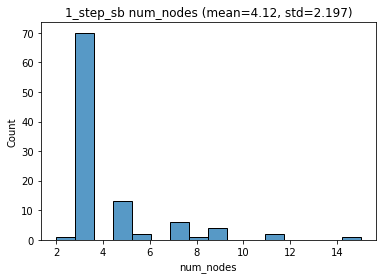

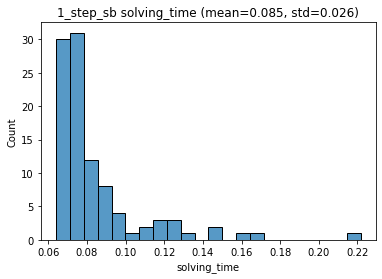

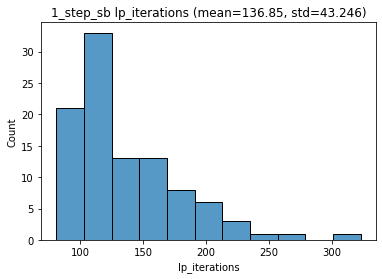

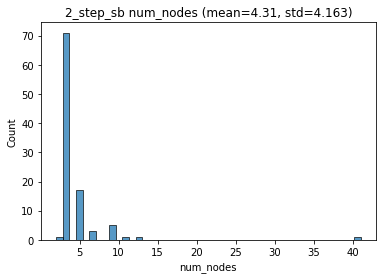

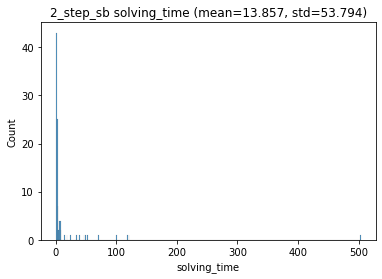

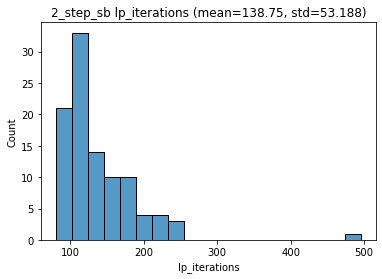

In [5]:
for agent in plot_dict.keys():
    for metric in plot_dict[agent].keys():
        fig = plt.figure()
        mean, std = np.mean(plot_dict[agent][metric]), np.std(plot_dict[agent][metric])
        title = f'{agent} {metric} (mean={round(mean, 3)}, std={round(std, 3)})'
        sns.histplot(plot_dict[agent][metric], edgecolor='k')
        plt.title(title)
        plt.xlabel(metric)
        plt.show()

# 2 key observations

From above code, there are 2 key observations:

1. SCIP strong branching scores are not the same as the total change in the dual bound - e.g. variables which have a 0 change in dual bound might still have highest strong branching score. As such, suspect that there is something under the hood which is doing more than just a 1-step lookahead to predict which variables will be better long term.

2. On an instance-by-instance basis, due to SCIP backend controlling node selection, pruning, etc., 2-step SB can end up with more nodes than 1-step SB

## Observation 1: SCIP SB scores != change in dual bound

## Observation 2: 1-step SB can have fewer nodes than 2-step SB